In [1]:
# Import generic utils
import os
import glob
import random

# Import math libs
import numpy as np
import pandas as pd

# Import image processing libs
import cv2

# Import the keras layers
from keras.models import model_from_json, load_model, Model, Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.layers import Deconvolution2D, Merge, Input, merge, Reshape, UpSampling2D
from keras.models import model_from_json
from keras.layers.core import Activation
from keras.optimizers import SGD
from keras.utils.visualize_util import plot
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import os
import numpy as np
import cv2
import pandas as pd
from IPython.display import HTML
from moviepy.editor import VideoFileClip
%matplotlib inline

In [3]:
# WEIGHTS_PATH = '/root/.keras/models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
WEIGHTS_PATH = '/root/sharefolder/sdcnd/CarND-Behavioral-Cloning-P3/vgg16_weights.h5'
TRAIN_DATA_PATH = '/root/sharefolder/sdc-data/kitti_lane_det/train/'
TEST_DATA_PATH = '/root/sharefolder/sdc-data/kitti_lane_det/test/'
TRANS_RANGE = 150

In [5]:
def img_change_brightness(img):
#     print (img.shape)
    temp = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    random_bright = np.random.uniform(low = -25., high = 25.)
#     random_bright = np.random.uniform()
    rand_i = np.random.randint(3)
    temp[:,:,rand_i] = temp[:,:,rand_i] + random_bright
    img = cv2.cvtColor(temp,cv2.COLOR_HSV2RGB)
    return img

def img_trans(img,gt):
    # Before preprocessing
    rand_x = np.random.uniform()
    rand_y = np.random.uniform()
    tr_x = TRANS_RANGE*rand_x-TRANS_RANGE/2
    tr_y = 10*rand_y-10/2
    #tr_y = 0
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    shape = img.shape
    image_tr = cv2.warpAffine(img,Trans_M,(shape[1],shape[0]))
    gt_tr = cv2.warpAffine(gt,Trans_M,(shape[1],shape[0]))

    return image_tr,gt_tr

def img_pre_process(img):
    img = cv2.resize(img,(480,480), interpolation=cv2.INTER_AREA)
    #Normalise an image -0.5 to 0.5
    img = img/255. - .5
#     return np.resize(img, (1, IMG_ROWS, IMG_COLS, IMG_CH))
    return img


def gt_pre_process(gt):
    #assuming that input with cv2 img encoding
    gt = cv2.resize(gt,(480,480), interpolation=cv2.INTER_AREA)
    gt_label = np.zeros((480, 480, 2))
    for row in range(480):
        for col in range(480):
            if gt[row,col,0] == 255 and  gt[row,col,2] == 255:
                gt_label[row,col,1] = 1
            else:
                gt_label[row,col,0] = 1
    return gt_label

    
def data_pre_process(img_name):
    img = cv2.imread(TRAIN_DATA_PATH + 'img/' + img_name)
#     print (img.shape)
    gt = cv2.imread(TRAIN_DATA_PATH + 'gt_img/' + img_name)
    img = img_change_brightness(img)
    img, gt = img_trans(img,gt)
    img = img_pre_process(img)
    img = np.resize(img, (1, 480, 480, 3))
    gt = gt_pre_process(gt)
#     gt = np.concatenate([np.zeros((int(480*480/2), 2)), np.ones((int(480*480/2), 2))])
#     a = np.zeros((480*480, 2))
#     for i in a:
#         i[np.random.randint(2)] = 1
#     gt = a
    gt = np.resize(gt, (1, 480* 480, 2))
    return img, gt

def test_pre_process(img_name, model):
    img = cv2.imread(TEST_DATA_PATH + img_name)
    processed_img = img_pre_process(img)
    tensor_img = np.resize(processed_img, (1, 480, 480, 3))
    predicted = model.predict(tensor_img)
    resized_pre = np.resize(predicted, (480, 480, 2))
    colored_pre = np.zeros((480, 480, 3))
    img = cv2.resize(img,(480,480), interpolation=cv2.INTER_AREA)
    for row in range(480):
        for col in range(480):
            if resized_pre[row][col][1] > 0.5:
                img[row][col][1] = 255
    return img
    
    


def train_data_generator(imgs_name):
    while 1:
        img_name = random.choice(imgs_name)
        img, gt = data_pre_process(img_name)
        yield img, gt

def val_data_generator(val_imgs_name):
    while 1:
        img_name = random.choice(val_imgs_name)
        img, gt = data_pre_process(img_name)
        yield img, gt

def pre_predict(data):
    x, y = data_pre_process(data)
    lane_truth = 0
    road_truth = 0
    for ind in y[0]:
        if ind[1] == 1:
            lane_truth += 1
        else:
            road_truth += 1   
    
    lane_true_positive = 0
    lane_true_negative = 0
    lane_false_positive = 0
    lane_false_negative = 0
    
    bin_a = 0
    bin_b = 0
    bin_c = 0
    bin_d = 0
    accuracy = 0
    
    predicted = model.predict(x)
    for pix_ind in range(len(predicted[0])):
        if y[0][pix_ind][1] == 1:
            if predicted[0][pix_ind][1] > 0.5:
                lane_true_positive += 1
                accuracy += 1
            else:
                lane_true_negative += 1
        else:
            if predicted[0][pix_ind][1] > 0.5:
                lane_false_positive += 1
            else:
                lane_false_negative += 1
                accuracy += 1
        
        
        if predicted[0][pix_ind][1] > .0 and predicted[0][pix_ind][1] < .25:
            bin_a += 1
        elif predicted[0][pix_ind][1] > .25 and predicted[0][pix_ind][1] < .5:
            bin_b += 1
        elif predicted[0][pix_ind][1] > .5 and predicted[0][pix_ind][1] < .75:
            bin_c += 1
        else:
            bin_d += 1
        
    accuracy_pro = float(accuracy/len(predicted[0]))
    print ('Accuracy {}'.format(accuracy_pro))
    print('Predict Lane :', lane_true_positive + lane_false_positive)
    print('Predict Road :', lane_true_negative + lane_false_negative)
    print('GT lane :', lane_truth)
    print('GT road :', road_truth)
    print('True positive :', lane_true_positive)
    print('True negative :', lane_true_negative)
    print('False positive :', lane_false_positive)
    print('False negative :', lane_false_negative)
    print('Predicted lane, .0~.25: {}, .25~.5: {}, .5~.75: {}, .75~1.: {}'.format(bin_a, bin_b, bin_c, bin_d))

def number_of_positive(train, validate):
    train_a = train[0]
    validate_a = validate[0]
    pre_predict(train_a)
    pre_predict(validate_a)
    
def save_model(model, epoch=''):
    model.save_weights('upsample_b'+str(epoch)+'.h5')
#     model.save('model'+str(epoch))
    print('Model saved')
    
    
def train_model(model, train_data, val_data):
    # Get an evaluation on the validation set
#     val_loss = model.evaluate_generator(val_data_generator(val_data), val_samples=5)

    #sanity check
#     val_loss = model.evaluate_generator(val_data_generator(train_data), val_samples=1)
#     print('Pre-trained evaluation loss = {}'.format(val_loss))

    # Try some predictions before we start..
#     test_predictions(model, train_data)
    num_runs = 0
    while True:

        print('Run {}'.format(num_runs+1))

        history = model.fit_generator(
            train_data_generator(train_data),
            samples_per_epoch= 20 ,
            nb_epoch=1,
            validation_data=val_data_generator(val_data),
            nb_val_samples=3,
            verbose=1)
        num_runs += 1

        number_of_positive(train_data, val_data)
        # Print out the test predictions
#         test_predictions(model, train_data)
        if num_runs % 50 == 0:
            save_model(model, num_runs)
#         save_model(model, num_runs)
        if num_runs > 1000:
            break

In [6]:
def get_model():
    img_input = Input(shape=(480, 480, 3), name = 'input')
    
#     pre_process = Lambda(lambda x: (x / 255.0) - 0.5, name = 'pre-process')(img_input)
    # Block 1
    b1_c1 = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv1')(img_input)
    b1_c2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv2')(b1_c1)
    b1_pool = MaxPooling2D((2, 2))(b1_c2)

    # Block 2
    b2_c1 = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv1')(b1_pool)
    b2_c2 = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv2')(b2_c1)
    b2_pool = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(b2_c2)

    # Block 3
    b3_c1 = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv1')(b2_pool)
    b3_c2 = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv2')(b3_c1)
    b3_c3 = Convolution2D(256, 3, 3, activation='relu', border_mode='same', name='block3_conv3')(b3_c2)
    b3_pool = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(b3_c3)

    # Block 4
    b4_c1 = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv1')(b3_pool)
    b4_c2 = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv2')(b4_c1)
    b4_c3 = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block4_conv3')(b4_c2)
    b4_pool = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(b4_c3)

    # Block 5
    b5_c1 = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv1')(b4_pool)
    b5_c2 = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv2')(b5_c1)
    b5_c3 = Convolution2D(512, 3, 3, activation='relu', border_mode='same', name='block5_conv3')(b5_c2)
    b5_pool = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(b5_c3)

    #FC-conv
    fc_conv1 = Convolution2D(1024, 3, 3, border_mode='same', name='FC-conv', 
                             init = 'glorot_normal')(b5_pool)
    batch_fc_conv1 = BatchNormalization(name = 'batch1-fc1')(fc_conv1)
    relu_fc_conv1 = Activation("relu")(batch_fc_conv1)
    fc_conv2 = Convolution2D(1024, 1, 1, activation='relu', border_mode='same', name='FC-conv2',
                            init = 'glorot_normal')(fc_conv1)
    batch_fc_conv2 = BatchNormalization(name = 'batch1-fc2')(fc_conv2)
    relu_fc_conv2 = Activation("relu")(batch_fc_conv2)
    
    #Up-conv1
    up_sample1 = UpSampling2D(size=(2, 2), name = 'upsample1')(relu_fc_conv2)
    up_conv1 = Convolution2D(6, 4, 4, border_mode='same', name='upconv1', init = 'glorot_normal')(up_sample1)
    batch_up_conv1 = BatchNormalization(name = 'batch1-a')(up_conv1)
    relu_up_conv1 = Activation("relu")(batch_up_conv1)
    
    pool_conv1 = Convolution2D(6, 1, 1, 
                                  border_mode='same', name='b4_pool_conv', init = 'glorot_normal')(b4_pool)
    batch_pool_conv1 = BatchNormalization(name = 'batch1-b')(pool_conv1)
    merged_up_conv1 = merge([relu_up_conv1, batch_pool_conv1], mode='sum', name = 'merged_up_conv1')

    #Up-conv2
    up_sample2 = UpSampling2D(size=(2, 2), name = 'upsample2')(merged_up_conv1)
    up_conv2 = Convolution2D(6, 4, 4, border_mode='same', name='upconv2', init = 'glorot_normal')(up_sample2)
    batch_up_conv2 = BatchNormalization(name = 'batch2-a')(up_conv2)
    relu_up_conv2 = Activation("relu")(batch_up_conv2)
    
    pool_conv2 = Convolution2D(6, 1, 1, 
                                  border_mode='same', name='b3_pool_conv', init = 'glorot_normal')(b3_pool)
    batch_pool_conv2 = BatchNormalization(name = 'batch2-b')(pool_conv2)
    merged_up_conv2 = merge([relu_up_conv2, batch_pool_conv2], mode='sum', name = 'merged_up_conv2')
    
#     up_conv2_deconv = Deconvolution2D(4, 4, 4, output_shape=(None, 60, 60, 4),
#                               subsample=(2, 2), border_mode='same', input_shape=(30, 30, 4),
#                                       name='deconv2', init = 'glorot_normal')(up_conv1)
#     batch_up_conv2_deconv = BatchNormalization(name = 'batch2-a')(up_conv2_deconv)
    
#     up_conv2_conv = Convolution2D(4, 1, 1, 
#                                   border_mode='same', name='b3_pool_conv', init = 'glorot_normal')(b3_pool)
#     batch_up_conv2_conv = BatchNormalization(name = 'batch2-b')(up_conv2_conv)
#     relu_up_conv2_conv = Activation("relu")(batch_up_conv2_conv)
#     up_conv2 = merge([batch_up_conv2_deconv, relu_up_conv2_conv], mode='sum', name = 'up_conv2')

    #Up-conv3
    up_sample3 = UpSampling2D(size=(2, 2), name = 'upsample3')(merged_up_conv2)
    up_conv3 = Convolution2D(6, 4, 4, border_mode='same', name='upconv3', init = 'glorot_normal')(up_sample3)
    batch_up_conv3 = BatchNormalization(name = 'batch3-a')(up_conv3)
    relu_up_conv3 = Activation("relu")(batch_up_conv3)
    
    pool_conv3 = Convolution2D(6, 1, 1, 
                                  border_mode='same', name='b2_pool_conv', init = 'glorot_normal')(b2_pool)
    batch_pool_conv3 = BatchNormalization(name = 'batch3-b')(pool_conv3)
    merged_up_conv3 = merge([relu_up_conv3, batch_pool_conv3], mode='sum', name = 'merged_up_conv3')
    
#     up_conv3_deconv = Deconvolution2D(4, 4, 4, output_shape=(None, 120, 120, 4),
#                               subsample=(2, 2), border_mode='same', input_shape=(60, 60, 4),
#                                       init = 'glorot_normal', name='deconv3')(up_conv2)
#     batch_up_conv3_deconv = BatchNormalization(name = 'batch3-a')(up_conv3_deconv)
    
#     up_conv3_conv = Convolution2D(4, 1, 1, init = 'glorot_normal',
#                                   border_mode='same', name='b2_pool_conv')(b2_pool)
#     batch_up_conv3_conv = BatchNormalization(name = 'batch3-b')(up_conv3_conv)
#     relu_up_conv3_conv = Activation("relu")(batch_up_conv3_conv)
#     up_conv3 = merge([batch_up_conv3_deconv, relu_up_conv3_conv], mode='sum', name = 'up_conv3')

    #Up-conv4
    up_sample4 = UpSampling2D(size=(2, 2), name = 'upsample4')(merged_up_conv3)
    up_conv4 = Convolution2D(6, 4, 4, border_mode='same', name='upconv4', init = 'glorot_normal')(up_sample4)
    batch_up_conv4 = BatchNormalization(name = 'batch4-a')(up_conv4)
    relu_up_conv4 = Activation("relu")(batch_up_conv4)
    
    pool_conv4 = Convolution2D(6, 1, 1, 
                                  border_mode='same', name='b1_pool_conv', init = 'glorot_normal')(b1_pool)
    batch_pool_conv4 = BatchNormalization(name = 'batch4-b')(pool_conv4)
    merged_up_conv4 = merge([relu_up_conv4, batch_pool_conv4], mode='sum', name = 'merged_up_conv4')
    
#     up_conv4_deconv = Deconvolution2D(4, 4, 4, output_shape=(None, 240, 240, 4),
#                               subsample=(2, 2), border_mode='same', input_shape=(120, 120, 4),
#                                       name='deconv4', init = 'glorot_normal')(up_conv3)
#     batch_up_conv4_deconv = BatchNormalization(name = 'batch4-a')(up_conv4_deconv)
    
#     up_conv4_conv = Convolution2D(4, 4, 4,  
#                                   border_mode='same', name='b1_pool_conv', init = 'glorot_normal')(b1_pool)
#     batch_up_conv4_conv = BatchNormalization(name = 'batch4-b')(up_conv4_conv)
#     relu_up_conv4_conv = Activation("relu")(batch_up_conv4_conv)
#     up_conv4 = merge([batch_up_conv4_deconv, relu_up_conv4_conv], mode='sum', name = 'up_conv4')

    #Up-conv5
    up_sample5 = UpSampling2D(size=(2, 2), name = 'upsample5')(merged_up_conv4)
    up_conv5 = Convolution2D(2, 4, 4, border_mode='same', name='upconv5', init = 'glorot_normal')(up_sample5)
#     up_conv5 = Deconvolution2D(2, 4, 4, output_shape=(None, 480, 480, 2),
#                               subsample=(2, 2), border_mode='same', input_shape=(240, 240, 4),
#                                name='deconv5', init = 'glorot_normal')(up_conv4)
    batch_up_conv5_conv = BatchNormalization(name = 'batch5')(up_conv5)
    reshape = Reshape((480*480, 2))(batch_up_conv5_conv)
    out = Activation("sigmoid")(reshape)
#     flat = Flatten(input_shape=vgg16_model.output_shape[1:])
#     flat = Flatten()(out)

    
    model = Model(img_input, out)
    plot(model, to_file='model.png')
    
#     for layer in model.layers[27:-4]:
#         print ("untrainable", layer)
#         layer.trainable = False
#     for layer in model.layers[:11]:
#         print ("untrainable", layer)
#         layer.trainable = False
    
#     model.compile(optimizer=SGD(lr=1e-3,  momentum=0.9), loss='categorical_crossentropy',metrics=['accuracy'])
#     model.compile(optimizer=SGD(lr=1e-4*2,  momentum=0.9), loss='binary_crossentropy',metrics=['accuracy'])
    model.compile(optimizer=SGD(lr=1e-6,  momentum=0.9), loss='binary_crossentropy',metrics=['accuracy'])
#     model.summary()
    return model

In [7]:
model = get_model()
model.load_weights('./model600.h5')
def movie_pre_process(img):
#     img = cv2.imread(TEST_DATA_PATH + img_name)
    processed_img = img_pre_process(img)
    tensor_img = np.resize(processed_img, (1, 480, 480, 3))
    predicted = model.predict(tensor_img)
    resized_pre = np.resize(predicted, (480, 480, 2))
    colored_pre = np.zeros((480, 480, 3))
    img = cv2.resize(img,(480,480), interpolation=cv2.INTER_AREA)
    for row in range(480):
        for col in range(480):
            if resized_pre[row][col][1] > 0.5:
                img[row][col][1] = 255
    return img
    
    

ValueError: Layer #17 (named "batch1-a" in the current model) was found to correspond to layer deconv1 in the save file. However the new layer batch1-a expects 4 weights, but the saved weights have 2 elements.

In [ ]:
#Creating video 
test1_output = 'test2.mp4'
clip1 = VideoFileClip("test_video.mp4")
test1_clip = clip1.fl_image(movie_pre_process) #NOTE: this function expects color images!!
%time test1_clip.write_videofile(test1_output, audio=False)

In [10]:
#learning rate 1e-6 full trainable, save weight as upsample_b, continue from upsample_a250
imgs_name = []
images = glob.glob('/root/sharefolder/sdc-data/kitti_lane_det/train/gt_img/*.png')
for i in images:
    imgs_name.append(i[-13:])
np.random.seed(200)
train, validate = np.split(imgs_name, [int(.95 * len(imgs_name))])
# Create a model
model = get_model()
model.load_weights('./upsample_a250.h5')
# Train the model
train_model(model, train, validate)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input (InputLayer)               (None, 480, 480, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 480, 480, 64)  1792        input[0][0]                      
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 480, 480, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 240, 240, 64)  0           block1_conv2[0][0]               
___________________________________________________________________________________________

KeyboardInterrupt: 

In [30]:
#learning rate 1e-4*2/3 full trainable, save weight as upsample_a, continue from upsample250
imgs_name = []
images = glob.glob('/root/sharefolder/sdc-data/kitti_lane_det/train/gt_img/*.png')
for i in images:
    imgs_name.append(i[-13:])
np.random.seed(200)
train, validate = np.split(imgs_name, [int(.95 * len(imgs_name))])
# Create a model
model = get_model()
model.load_weights('./upsample250.h5')
# Train the model
train_model(model, train, validate)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input (InputLayer)               (None, 480, 480, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 480, 480, 64)  1792        input[0][0]                      
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 480, 480, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
maxpooling2d_5 (MaxPooling2D)    (None, 240, 240, 64)  0           block1_conv2[0][0]               
___________________________________________________________________________________________

KeyboardInterrupt: 

In [24]:
#upsample learning rate 1e-4*2
imgs_name = []
images = glob.glob('/root/sharefolder/sdc-data/kitti_lane_det/train/gt_img/*.png')
for i in images:
    imgs_name.append(i[-13:])
np.random.seed(200)
train, validate = np.split(imgs_name, [int(.95 * len(imgs_name))])
# Create a model
model = get_model()

# Train the model
train_model(model, train, validate)


untrainable <keras.engine.topology.InputLayer object at 0x7fed47a8b7f0>
untrainable <keras.layers.convolutional.Convolution2D object at 0x7fed47a8b6d8>
untrainable <keras.layers.convolutional.Convolution2D object at 0x7fed471f1710>
untrainable <keras.layers.pooling.MaxPooling2D object at 0x7fed4721cef0>
untrainable <keras.layers.convolutional.Convolution2D object at 0x7fed472287f0>
untrainable <keras.layers.convolutional.Convolution2D object at 0x7fed47231ef0>
untrainable <keras.layers.pooling.MaxPooling2D object at 0x7fed471d4940>
untrainable <keras.layers.convolutional.Convolution2D object at 0x7fed471e6240>
untrainable <keras.layers.convolutional.Convolution2D object at 0x7fed471f6940>
untrainable <keras.layers.convolutional.Convolution2D object at 0x7fed47191710>
untrainable <keras.layers.pooling.MaxPooling2D object at 0x7fed471ad5c0>
____________________________________________________________________________________________________
Layer (type)                     Output Shape   

KeyboardInterrupt: 

In [8]:
# np.random.seed(200)

# # Load the data
# original_df = pd.read_csv(os.path.join(PATH, 'driving_log.csv'))

# # Crop the data
# cropped_df = prepare_df(original_df)

# # Shuffle and split the data set
# validate, train = np.split(cropped_df.sample(frac=1), [BATCH])
# del total_data
imgs_name = []
images = glob.glob('/root/sharefolder/sdc-data/kitti_lane_det/train/gt_img/*.png')
# train = images[:5]
for i in images:
    imgs_name.append(i[-13:])
np.random.seed(200)
train, validate = np.split(imgs_name, [int(.95 * len(imgs_name))])
# Create a model
model = get_model()

# Train the model
train_model(model, train, validate)



Run 1
Epoch 1/1
12/20 [=================>............] - ETA: 53s - loss: 0.7824 - acc: 0.5028

KeyboardInterrupt: 

In [165]:
a = test_pre_process('um_000010.png', model)

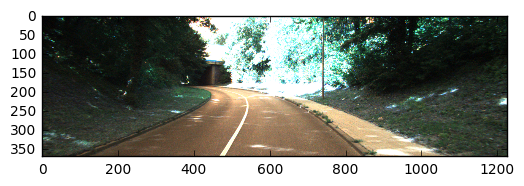

In [153]:
plt.imshow(cv2.imread(TEST_DATA_PATH + 'um_000090.png'))

In [55]:
train[:2]

['um_000091.png']

In [108]:
np.random.seed(200)
np.split(train, [int(.9 * len(train))])

[array(['um_000091.png', 'um_000067.png', 'um_000042.png', 'um_000020.png',
        'um_000045.png', 'um_000025.png', 'um_000054.png', 'um_000092.png',
        'um_000076.png', 'um_000051.png', 'um_000032.png', 'um_000069.png',
        'um_000028.png', 'um_000062.png', 'um_000094.png', 'um_000001.png',
        'um_000052.png', 'um_000053.png', 'um_000084.png', 'um_000073.png',
        'um_000014.png', 'um_000006.png', 'um_000050.png', 'um_000009.png',
        'um_000037.png', 'um_000029.png', 'um_000060.png', 'um_000030.png',
        'um_000058.png', 'um_000093.png', 'um_000026.png', 'um_000065.png',
        'um_000083.png', 'um_000015.png', 'um_000088.png', 'um_000036.png',
        'um_000024.png', 'um_000066.png', 'um_000070.png', 'um_000003.png',
        'um_000049.png', 'um_000010.png', 'um_000011.png', 'um_000046.png',
        'um_000023.png', 'um_000085.png', 'um_000019.png', 'um_000013.png',
        'um_000035.png', 'um_000087.png', 'um_000012.png', 'um_000038.png',
        'um_

In [173]:
np.random.seed(200)
train, validate = np.split(imgs_name, [int(.95 * len(imgs_name))])
validate

array(['um_000043.png', 'um_000089.png', 'um_000086.png', 'um_000021.png',
       'um_000016.png'], 
      dtype='<U13')

In [ ]:
clip1

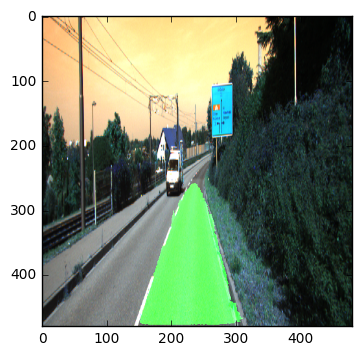

In [27]:
model.load_weights('./upsample_b200.h5')
img = test_pre_process('um_000036.png', model)
plt.imshow(img)

In [28]:
import matplotlib.image as mpimg
mpimg.imsave("out2.png", img)

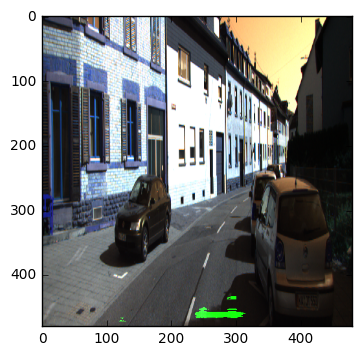

In [117]:
#plt.imshow(cv2.imread(TEST_DATA_PATH + 'um_000090.png'))
model.load_weights('./upsample_a250.h5')
plt.imshow(test_pre_process('um_000095.png', model))

In [168]:
validate

array(['um_000043.png', 'um_000089.png', 'um_000086.png', 'um_000021.png',
       'um_000016.png'], 
      dtype='<U13')

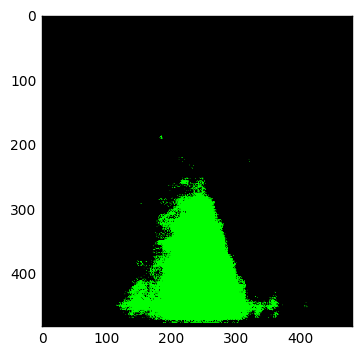

In [169]:
x, y = data_pre_process('um_000043.png')
predicted = model.predict(x)
resized_pre = np.resize(predicted, (480, 480, 2))
one_d = np.zeros((480, 480, 3))
for row in range(480):
    for col in range(480):
        if resized_pre[row][col][1] > 0.5:
            one_d[row][col][1] = 1
plt.imshow(one_d)

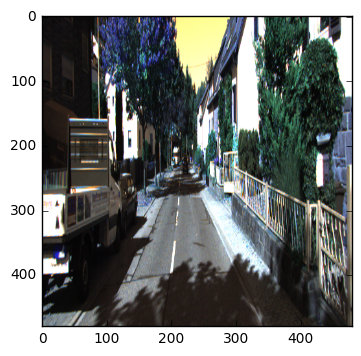

In [175]:
plt.imshow(cv2.resize(cv2.imread(TRAIN_DATA_PATH + 'img/um_000090.png'), (480, 480)))

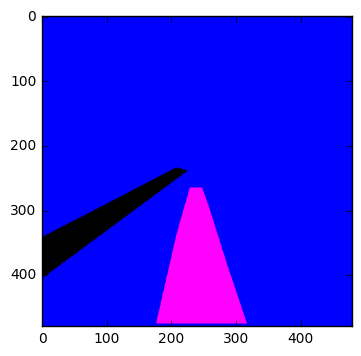

In [133]:
plt.imshow(cv2.resize(cv2.imread(TRAIN_DATA_PATH + 'gt_img/um_000021.png'), (480, 480)))

In [34]:
x.shape

(1, 480, 480, 3)

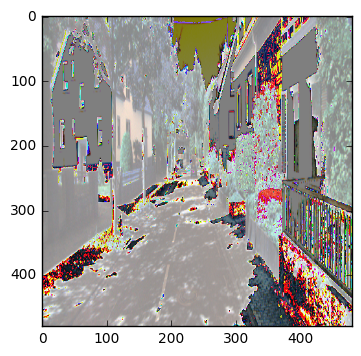

In [36]:
plt.imshow(np.resize(x, (480,480,3)))

In [18]:
# predicted = model.predict(x)
for i in predicted[0]:
    if i[1] > 0.5:
#         print (i)

SyntaxError: unexpected EOF while parsing (<ipython-input-18-9f3a75f97060>, line 4)

In [ ]:
from keras.utils.np_utils import probas_to_classes

In [ ]:
count = 0
for i in np.array([1 if p[1] > 0.5 else 0 for p in predicted[0]]):
#     print (i)
    if i == 1:
        count += 1

In [ ]:
count

In [ ]:
for p in predicted[0]:
    print(p[0])

In [ ]:
model.predict_classes(x, batch_size=1, verbose=1)

In [ ]:
predicted[0][127][0] + predicted[0][127][1]

In [ ]:
y[0][127]

In [ ]:
predicted = model.predict_classes(x)

In [ ]:
images = glob.glob('/root/sharefolder/sdc-data/kitti_lane_det/train/gt_img/*.png')

In [ ]:
images[:5]

In [ ]:
right_train_images = glob.glob('/root/sharefolder/sdc-data/kitti_lane_det/train/gt_img/*.png')

In [ ]:
for i in right_train_images:
    print (i[-13:])
    break

In [ ]:
right_imgs = []
for i in right_train_images:
    if i[-13:-11] == 'uu':
        right_imgs.append(i)

In [ ]:
len(right_imgs)

In [ ]:
for image in right_train_images:
    with open(image, 'rb') as f:
        data = f.read()

    output = '/root/sharefolder/sdc-data/kitti_lane_det/train/gt_img/um' + image[-11:]
    with open(output, 'wb') as f:
        f.write(data)

In [ ]:
1/(480*480*2)

In [ ]:
import math
-math.log(2.17e-6)*480*480*2

In [ ]:
img = cv2.imread('/root/sharefolder/sdc-data/kitti/data_road/training/image_2/um_000001.png')
gt = cv2.imread('/root/sharefolder/sdc-data/kitti/data_road/training/gt_image_2/um_lane_000001.png')

In [ ]:
re_gt = cv2.resize(gt,(480,480), interpolation=cv2.INTER_AREA)

In [ ]:
gt.shape

In [ ]:
gt_label = np.zeros((375, 1242, 3))
a = 0
for row in range(len(gt[:,:,0])):
    for col in range(len(gt[row,:,0])):
        a += 1
        if gt[row,col,0] == 255 and  gt[row,col,2] == 255:
            gt_label[row,col,1] = 1

In [ ]:
gt_label.shape

In [ ]:
plt.imshow(gt_label)

In [ ]:
plt.imshow(cv2.resize(gt_label,(480,480), interpolation=cv2.INTER_AREA))

In [ ]:
a

In [ ]:
gt[1,1,0]

In [ ]:
if re_gt[:,:,0].any() == 255:
    zero[:,:,0] = 1

In [ ]:
re_gt[:,234,0]

In [ ]:
zero[:,234,0]

In [ ]:
a = 0
for i in re_gt[:,:,0]:
    a +=1

In [ ]:
a

In [ ]:
i, g = img_trans(img_pre_process(img),img_pre_process(gt))

In [ ]:
img.shape

In [ ]:
plt.imshow(i)

In [ ]:
plt.imshow(g)

In [ ]:
plt.imshow(gt)

In [ ]:
np.random.randint(3)

In [26]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import os
import numpy as np
import cv2
import pandas as pd
%matplotlib inline


In [ ]:
plt.imshow(img_pre_process(img_change_brightness(a)))

In [ ]:
a.shape

In [ ]:
a = cv2.imread('/root/sharefolder/sdc-data/kitti/data_road/training/image_2/um_000001.png')

In [ ]:
plt.imshow(a)

In [ ]:
plt.imshow(img_change_brightness(img_pre_process(a)))

In [ ]:
if os.path.exists('/root/sharefolder/sdc-data/kitti/data_road/training/gt_image_2'):
    print(True)
else:
    False